In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import pandas as pd
import numpy as np
import os, random, json, matplotlib.pyplot as plt
from rapidfuzz import process

In [2]:
IMG_SIZE = 128
BATCH_SIZE = 32

train_df = pd.read_csv("../data/clean/train_cleaned.csv")
test_df = pd.read_csv("../data/clean/test_cleaned.csv")

def load_and_preprocess_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = img / 255.0
    return img, label

def get_image_path(name):
    return os.path.join("../data/raw/food-101/images", name + ".jpg")

train_df["image_path"] = train_df["image_name"].apply(get_image_path)
test_df["image_path"] = test_df["image_name"].apply(get_image_path)

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_df["label_encoded"] = label_encoder.fit_transform(train_df["label"])
test_df["label_encoded"] = label_encoder.transform(test_df["label"])

label_map = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

train_ds = tf.data.Dataset.from_tensor_slices((train_df["image_path"], train_df["label_encoded"]))
train_ds = train_ds.map(load_and_preprocess_image).shuffle(2000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((test_df["image_path"], test_df["label_encoded"]))
test_ds = test_ds.map(load_and_preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [3]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.1)
])

base_model = MobileNetV2(include_top=False, weights="imagenet", input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.4)(x)
outputs = Dense(len(label_encoder.classes_), activation="softmax")(x)

model = Model(inputs, outputs)
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 101)            │        25,957 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,611,877 (9.96 MB)

 Trainable params: 353,893 (1.35 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [4]:
early_stop = EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1)
checkpoint = ModelCheckpoint("../data/clean/mobilenet_food101_best.keras", save_best_only=True)

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10,
    callbacks=[early_stop, lr_scheduler, checkpoint]
)

model.save("../data/clean/mobilenet_food101_initial.keras")

Epoch 1/10
2602/2602 ━━━━━━━━━━━━━━━━━━━━ 343s 131ms/step - accuracy: 0.3167 - loss: 3.0017 - val_accuracy: 0.0241 - val_loss: 5.5017 - learning_rate: 1.0000e-04
Epoch 2/10
2602/2602 ━━━━━━━━━━━━━━━━━━━━ 336s 129ms/step - accuracy: 0.3843 - loss: 2.3206 - val_accuracy: 0.0553 - val_loss: 5.8622 - learning_rate: 1.0000e-04
Epoch 3/10
2602/2602 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.5052 - loss: 1.6939
Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
2602/2602 ━━━━━━━━━━━━━━━━━━━━ 349s 134ms/step - accuracy: 0.5052 - loss: 1.6939 - val_accuracy: 0.0799 - val_loss: 5.9499 - learning_rate: 1.0000e-04
Epoch 4/10
2602/2602 ━━━━━━━━━━━━━━━━━━━━ 423s 162ms/step - accuracy: 0.5016 - loss: 1.6895 - val_accuracy: 0.0956 - val_loss: 5.6818 - learning_rate: 5.0000e-05
Epoch 5/10
2602/2602 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.5364 - loss: 1.5416
Epoch 5: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
2602/2602 ━━━━━━━━━━━━━━━━━━━━ 

In [5]:
base_model.trainable = True
for layer in base_model.layers[:-60]:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

fine_tune_history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10,
    callbacks=[early_stop, lr_scheduler]
)

model.save("../data/clean/mobilenet_food101_finetuned.keras")

Epoch 1/10
2602/2602 ━━━━━━━━━━━━━━━━━━━━ 576s 219ms/step - accuracy: 0.2269 - loss: 3.1784 - val_accuracy: 0.1923 - val_loss: 3.4874 - learning_rate: 1.0000e-05
Epoch 2/10
2602/2602 ━━━━━━━━━━━━━━━━━━━━ 577s 222ms/step - accuracy: 0.2963 - loss: 2.7206 - val_accuracy: 0.1583 - val_loss: 3.8756 - learning_rate: 1.0000e-05
Epoch 3/10
2602/2602 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.3243 - loss: 2.5692
Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
2602/2602 ━━━━━━━━━━━━━━━━━━━━ 585s 224ms/step - accuracy: 0.3244 - loss: 2.5691 - val_accuracy: 0.1402 - val_loss: 4.1062 - learning_rate: 1.0000e-05
Epoch 4/10
2602/2602 ━━━━━━━━━━━━━━━━━━━━ 805s 309ms/step - accuracy: 0.2656 - loss: 2.8736 - val_accuracy: 0.2356 - val_loss: 3.1487 - learning_rate: 5.0000e-06
Epoch 5/10
2602/2602 ━━━━━━━━━━━━━━━━━━━━ 37067s 14s/step - accuracy: 0.2787 - loss: 2.9056 - val_accuracy: 0.3027 - val_loss: 2.8634 - learning_rate: 5.0000e-06
Epoch 6/10
2602/2602 ━━━━━━━━━━━━━━

790/790 ━━━━━━━━━━━━━━━━━━━━ 77s 97ms/step - accuracy: 0.2529 - loss: 3.1252
Final Test Accuracy: 0.3291
Final Test Loss: 2.8473


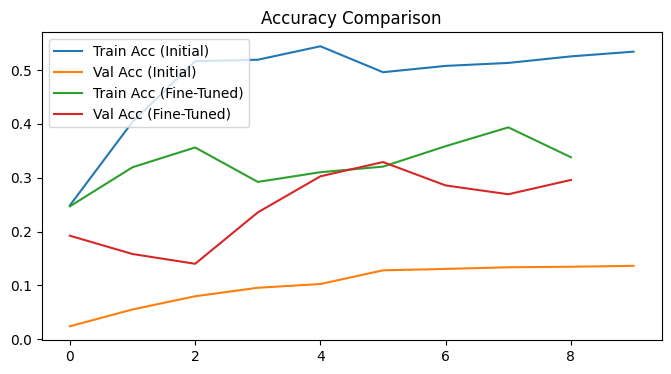

In [6]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Final Test Accuracy: {test_acc:.4f}")
print(f"Final Test Loss: {test_loss:.4f}")

plt.figure(figsize=(8, 4))
plt.plot(history.history["accuracy"], label="Train Acc (Initial)")
plt.plot(history.history["val_accuracy"], label="Val Acc (Initial)")
plt.plot(fine_tune_history.history["accuracy"], label="Train Acc (Fine-Tuned)")
plt.plot(fine_tune_history.history["val_accuracy"], label="Val Acc (Fine-Tuned)")
plt.legend()
plt.title("Accuracy Comparison")
plt.show()

In [7]:
usda_df = pd.read_csv("../data/raw/usda_food_data.csv")

def find_closest_food(food_name):
    descriptions = usda_df["description"].dropna().tolist()
    result = process.extractOne(food_name.replace("_", " "), descriptions)
    if result is None:
        return None
    match, score = result[0], result[1]  
    if score > 70:
        matched_row = usda_df[usda_df["description"].str.contains(match, case=False, na=False)]
        if not matched_row.empty:
            return matched_row.iloc[0]
    return None


def predict_food(img_path):
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = np.expand_dims(image.img_to_array(img) / 255.0, axis=0)
    pred = model.predict(img_array)
    pred_label = label_encoder.inverse_transform([np.argmax(pred)])[0]

    print(f"Predicted Food: {pred_label}")
    info = find_closest_food(pred_label)
    if info is not None:
        print("\nNutrition Info:")
        print(info[["description", "calories", "protein", "fat", "carbohydrates"]])
    else:
        print("No match found in USDA database.")

    
    plt.imshow(img)
    plt.axis("off")
    plt.title(pred_label)
    plt.show()


Testing image: ../data/raw/food-101/images/edamame/499783.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step
Predicted Food: edamame
No match found in USDA database.


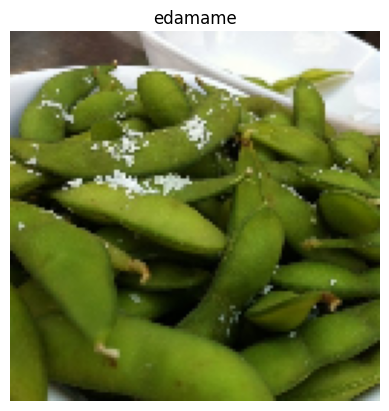


Testing image: ../data/raw/food-101/images/chocolate_mousse/3311725.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted Food: frozen_yogurt

Nutrition Info:
description      French toast, frozen
calories                        183.0
protein                          7.24
fat                              3.82
carbohydrates                   29.89
Name: 138, dtype: object


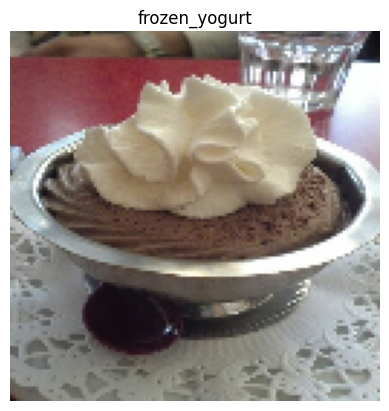


Testing image: ../data/raw/food-101/images/sushi/861296.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted Food: sushi

Nutrition Info:
description      Sushi, NFS
calories               94.0
protein                2.92
fat                    0.67
carbohydrates         18.39
Name: 314, dtype: object


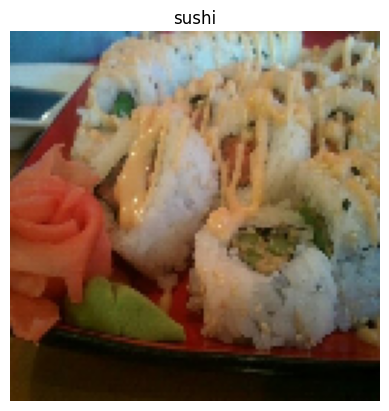


Testing image: ../data/raw/food-101/images/baby_back_ribs/3890499.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted Food: chocolate_mousse

Nutrition Info:
description      Pie, chocolate mousse, prepared from mix, no-b...
calories                                                     260.0
protein                                                        3.5
fat                                                           15.4
carbohydrates                                                 29.6
Name: 66, dtype: object


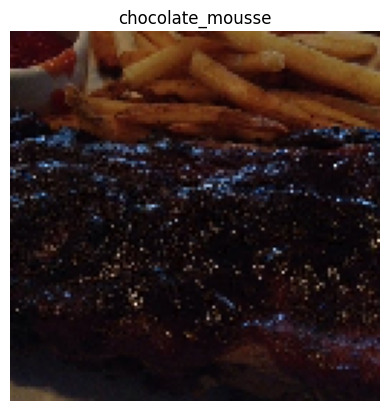


Testing image: ../data/raw/food-101/images/deviled_eggs/1846457.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted Food: scallops

Nutrition Info:
description      Scallops, fried
calories                   217.0
protein                    11.08
fat                        12.54
carbohydrates              14.14
Name: 283, dtype: object


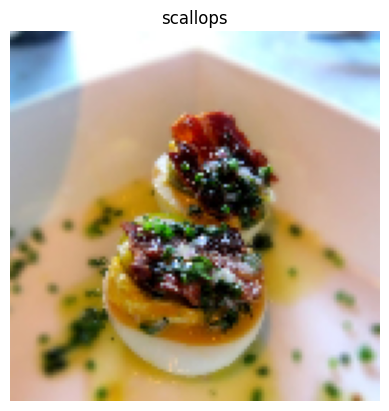

In [8]:
def test_multiple_predictions(num_samples=5):
    sample_paths = random.sample(test_df["image_path"].tolist(), num_samples)

    for path in sample_paths:
        print("\nTesting image:", path)
        predict_food(path)

# Test the model on 5 random images
test_multiple_predictions(num_samples=5)

In [9]:
import json

# Convert all keys and values to native Python types
label_map_serializable = {str(k): int(v) for k, v in label_map.items()}

with open("../data/clean/label_map.json", "w") as f:
    json.dump(label_map_serializable, f, indent=4)

print("Saved model")

Saved model
